In [2]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.set_random_seed(seed)

Using TensorFlow backend.


Set: train, bacterial images: 2538, viral images: 1345
Set: test, bacterial images: 242, viral images: 148


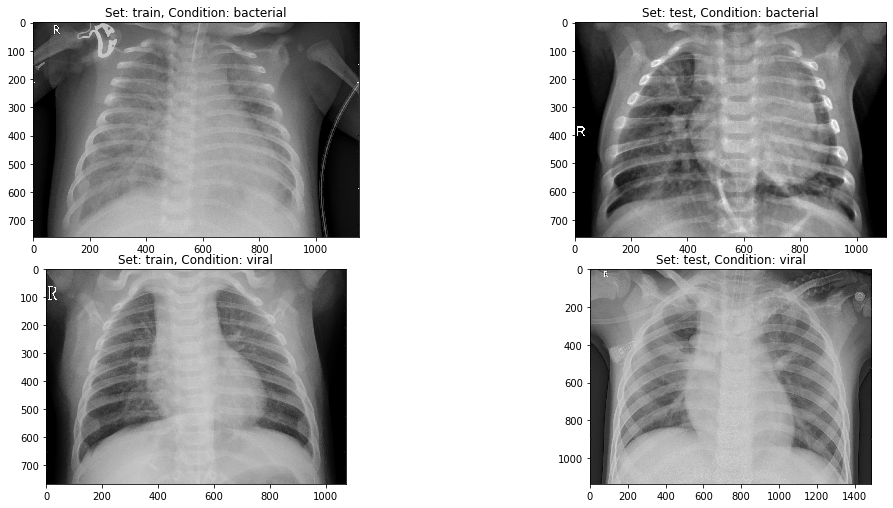

In [5]:
input_path = 'C:/Users/rituj/Desktop/project/chest_xray_try/'
class pre:
    fig, ax = plt.subplots(2, 2, figsize=(15, 7))
    ax = ax.ravel()
    plt.tight_layout()

    for i, _set in enumerate(['train', 'test']):
        set_path = input_path+_set
        ax[i].imshow(plt.imread(set_path+'/bacterial/'+os.listdir(set_path+'/bacterial')[0]), cmap='gray')
        ax[i].set_title('Set: {}, Condition: bacterial'.format(_set))
        ax[i+2].imshow(plt.imread(set_path+'/viral/'+os.listdir(set_path+'/viral')[0]), cmap='gray')
        ax[i+2].set_title('Set: {}, Condition: viral'.format(_set))
        
    for _set in ['train', 'test']:
        n_bacterial = len(os.listdir(input_path + _set + '/bacterial'))
        n_viral = len(os.listdir(input_path + _set + '/viral'))
        print('Set: {}, bacterial images: {}, viral images: {}'.format(_set, n_bacterial, n_viral))
    @staticmethod    
    def process_data(img_dims, batch_size):
        # Data generation objects
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
        test_val_datagen = ImageDataGenerator(rescale=1./255)

        # This is fed to the network in the specified batch sizes and image dimensions
        train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

        test_gen = test_val_datagen.flow_from_directory(
        directory=input_path+'test', 
        target_size=(img_dims, img_dims), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

        # I will be making predictions off of the test set in one batch size
        # This is useful to be able to get the confusion matrix
        test_data = []
        test_labels = []

        for cond in ['/bacterial/', '/viral/']:
            for img in (os.listdir(input_path + 'test' + cond)):
                img = plt.imread(input_path+'test'+cond+img)
                img = cv2.resize(img, (img_dims, img_dims))
                img = np.dstack([img, img, img])
                img = img.astype('float32') / 255
                if cond=='/bacterial/':
                    label = 0
                elif cond=='/viral/':
                    label = 1
                test_data.append(img)
                test_labels.append(label)

        test_data = np.array(test_data)
        test_labels = np.array(test_labels)

        return train_gen, test_gen, test_data, test_labels

In [6]:
img_dims = 150
epochs = 10
batch_size = 32
p=pre()
train_gen, test_gen, test_data, test_labels = p.process_data(img_dims, batch_size)
inputs = Input(shape=(img_dims, img_dims, 3))


Found 3883 images belonging to 2 classes.
Found 390 images belonging to 2 classes.




In [7]:
# Input layer
class third:
    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(units=1, activation='sigmoid')(x)

    # Creating model and compiling
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    @staticmethod    
    def callback():
        checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
        lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')
        callbacks=[checkpoint, lr_reduce]
        return callbacks











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# Fitting the model
m=third()
c=m.callback()
hist = m.model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=c)



Epoch 1/10
121/121 [==============================] - 171s 1s/step - loss: 0.6499 - acc: 0.6513 - val_loss: 0.6941 - val_acc: 0.4062
Epoch 2/10
121/121 [==============================] - 124s 1s/step - loss: 0.6220 - acc: 0.6754 - val_loss: 0.6894 - val_acc: 0.6257
Epoch 3/10
121/121 [==============================] - 140s 1s/step - loss: 0.6166 - acc: 0.6771 - val_loss: 0.5075 - val_acc: 0.8212

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
121/121 [==============================] - 121s 1s/step - loss: 0.5847 - acc: 0.7173 - val_loss: 0.4554 - val_acc: 0.8659
Epoch 5/10
121/121 [==============================] - 138s 1s/step - loss: 0.5753 - acc: 0.7116 - val_loss: 0.4350 - val_acc: 0.8492

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
121/121 [==============================] - 132s 1s/step - loss: 0.5642 - acc: 0.7248 - val_loss: 0.4506 - val_acc: 0.8408
Epoch 7/10
121/121 [==================

In [9]:
m.model.save('p2_c.h5')
class op:
    @staticmethod
    def plo():
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax = ax.ravel()

        for i, met in enumerate(['acc', 'loss']):
            ax[i].plot(hist.history[met])
            ax[i].plot(hist.history['val_' + met])
            ax[i].set_title('Model {}'.format(met))
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel(met)
            ax[i].legend(['train', 'val'])
    @staticmethod
    def op1():        
        from sklearn.metrics import accuracy_score, confusion_matrix

        preds = m.model.predict(test_data)

        acc = accuracy_score(test_labels, np.round(preds))*100
        cm = confusion_matrix(test_labels, np.round(preds))
        tn, fp, fn, tp = cm.ravel()

        print('CONFUSION MATRIX ------------------')
        print(cm)

        print('\nTEST METRICS ----------------------')
        precision = tp/(tp+fp)*100
        recall = tp/(tp+fn)*100
        print('Accuracy: {}%'.format(acc))
        print('Precision: {}%'.format(precision))
        print('Recall: {}%'.format(recall))
        print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

        print('\nTRAIN METRIC ----------------------')
        print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

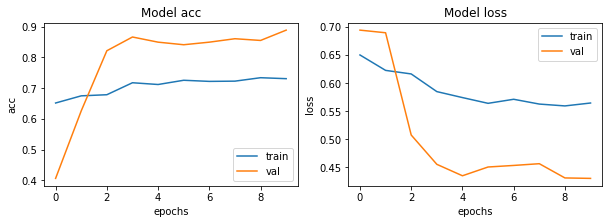

In [10]:
r=op()
r.plo()
r.op1()